In [1]:
#!/home/cpabla/anaconda3/envs/pysimba/bin/python
# coding: utf-8
import sys, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from zipfile import ZipFile
import xarray as xr
import time

import Parsivel_Utilities as pu
import Plot_Disdrometer as pltdsd
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 1100)
np.set_printoptions(linewidth=160)

#############################################################################################
if(__name__ == "__main__"):
    '''
        Code to load, analyze and plot PSD info from 2DVD disdrometer.

        Written by: David B. Wolff
                    Assistant Lab Chief
                    NASA Wallops Flight Facility
                    Wallops Flight Facility

        Last update: July 11, 2023
            
    '''
    site = 'WFF'
    inst = 'apu04'
    year  = 2021 ; syear  = str(year).zfill(2)
    month = 2    ; smonth = str(month).zfill(2)
    day   = 12   ; sday   = str(day).zfill(2)

    beg_prog = time.time()
    Out_Base_Dir = 'd1/wallops-prf/Disdrometer/Parsivel' # Home
    #Out_Base_Dir = '/d1/wallops-prf/Field_Campaigns/IMPACTS/'
    #Out_Base_Dir = '/home/cpabla/PyParsivel/'
    
    In_Base_Dir = '/Volumes/8M2/distro/apu/' # Home
    #In_Base_Dir = '/distro/apu/' # Web
    #In_Base_Dir = '/gpm_raid/distro/apu/'
    
    # if len(sys.argv) != 6:
    #     sys.exit("Usage: " + sys.argv[0] + " Site Inst Year Month Day")
    # else:
    #     site  = sys.argv[1]
    #     inst  = sys.argv[2].lower()
    #     year  = int(sys.argv[3]) ; syear  = str(year).zfill(2)
    #     month = int(sys.argv[4]) ; smonth = str(month).zfill(2)
    #     day   = int(sys.argv[5]) ; sday   = str(day).zfill(2)
    
    # Read diameter and velocity bin values
    DVparms = pd.read_csv('Tables/parsivel_diameter_py.txt', sep='\s+',index_col=False)

    # Read Ali's D/V mask
    DF_Mask = pd.read_csv('Tables/parsivel_conditional_matrix.txt', header=None)
    
    # Locate the data
    in_dir = In_Base_Dir + inst + '/' + syear + smonth + '/'    

    wc = f"{in_dir}/{inst}_{syear}{smonth}{sday}??.zip"
    zfiles = sorted(glob.glob(wc))
    nf = len(zfiles)
    if(nf == 0):
        error_text = 'No files found!'
        pltdsd.plot_error(error_text, 'DSD', Out_Base_Dir, site, inst, syear, smonth, sday)
        pltdsd.plot_error(error_text, 'Rain', Out_Base_Dir, site, inst, syear, smonth, sday)
        flag = 'Stopped on Files not Found error!  ' + wc
        print(flag)
        print()
        sys.exit()

    # Unzip the files and return the name of the unzipped files
    print('Unzipping input files...')
    files, tmp_dir = pu.unzip_files(zfiles, inst, syear, smonth, sday)

    # Concatenate 10 minute hourly files into a single daily file
    print('Concatenating files...')
    in_file = pu.concatenate_files(files)
    #os.rmdir(tmp_dir)
    
    # Get xarray DataSet from Parsive input file
    print('Reading data and returning Xarray dataset...', end=" ")
    beg_time = time.time()
    DS, data2d = pu.get_dataset_from_parsivel(in_file, DVparms, Order='F')
    end_time = time.time()
    delt = end_time-beg_time
    print(f' It took {np.round(delt,1)} seconds to load file!')
    
    # Resample 10 s data to one minute data
    print('Resampling 10-second data to 1-minute data and summing...')
    DS_1min = DS.resample(time='1T').sum()
    DS_1min = DS_1min.fillna(0)
    # del DS, data2d
    
    # Get integral parameters, PSD and Moments
    print('Getting Integral parameters, PSD and Moments from DataSet...')
    beg_time = time.time()
    Parms_DF, PSD_DF, Moments_DF = pu.get_integral_parameters(site, inst, DS_1min, DF_Mask, DVparms)
    end_time = time.time()
    delt = end_time-beg_time
    print(f' It took {np.round(delt,1)} seconds to retrieve DSD!')
    
    # Get integral parameters, PSD and Moments
    print('Getting Integral parameters, PSD and Moments from DataSet...')
    beg_time = time.time()
    Parms_DFx = pu.get_integral_parameters_xarray(site, inst, DS_1min, DF_Mask, DVparms)
    end_time = time.time()
    delt = end_time-beg_time
    print(f' It took {np.round(delt,1)} seconds to retrieve DSD via xarray!')

    '''
    # Save Parms_DF, PSD_DF and Moments to CSV files
    print('Saving Parms, DSD and Moments to CSV files...')
    parms_file, psd_file, moms_file = pu.save_dataframes(Parms_DF, PSD_DF, Moments_DF, Out_Base_Dir,
                                                         site, inst, syear, smonth, sday
                                                        
    # Save the 1-minute DataSet that includes masking to a NetCDF file
    # print('Saving DS_1min DataSet to a netcdf file...')
    # ncdf_file = pu.save_netcdf(DS_1min, site, inst, syear, smonth, sday)
    end_prog = time.time()
    delt = end_prog-beg_prog
    print(f'It took {np.round(delt,1)} seconds to process {site}/{inst}')
    '''
    print()
    print('Done.')
    

Unzipping input files...
Concatenating files...
Reading data and returning Xarray dataset...  It took 6.2 seconds to load file!
Resampling 10-second data to 1-minute data and summing...
Getting Integral parameters, PSD and Moments from DataSet...
 It took 10.3 seconds to retrieve DSD!
Getting Integral parameters, PSD and Moments from DataSet...
 It took 0.8 seconds to retrieve DSD via xarray!

Done.


### Look at Parms_DF

In [2]:
Parms_DF

,Total Drops,Concentration,LWC,Z,dBZ,Rain,Dm,Dmax,Sigma_M
2021-02-12 00:00:00,35,13.988598,0.255092,144577.235070,51.600999,8.499974,6.421650,7.725,0.0
2021-02-12 00:01:00,36,14.100340,0.083877,35606.142977,45.515249,2.767879,5.616567,6.695,0.0
2021-02-12 00:02:00,23,8.924515,0.037693,12090.777930,40.824542,1.252480,5.309661,5.665,0.0
2021-02-12 00:03:00,43,16.720151,0.155927,90126.744038,49.548537,5.167399,6.182785,7.725,0.0
2021-02-12 00:04:00,27,10.909152,0.040413,12226.912694,40.873168,1.326023,5.103819,5.665,0.0
...,...,...,...,...,...,...,...,...,...
2021-02-12 23:55:00,0,0.000000,0.000000,0.000000,-inf,0.000000,0.000000,0.000,0.0
2021-02-12 23:56:00,1,0.354752,0.000036,0.013366,-18.740041,0.001140,0.579000,0.579,0.0
2021-02-12 23:57:00,0,0.000000,0.000000,0.000000,-inf,0.000000,0.000000,0.000,0.0
2021-02-12 23:58:00,0,0.000000,0.000000,0.000000,-inf,0.000000,0.000000,0.000,0.0


### Look at PSD_DF

In [3]:
PSD_DF

,0.064,0.193,0.321,0.450,0.579,0.708,0.836,0.965,1.094,1.223,1.416,1.674,1.931,2.189,2.446,2.832,3.347,3.862,4.378,4.892,5.665,6.695,7.725,8.755,9.785,11.330,13.390,15.450,17.510,19.570,22.145,25.235
2021-02-12 00:00:00,0.0,0.0,0.0,0.0,23.135884,21.564761,10.999039,26.905319,2.892935,3.100224,0.000000,0.0,0.0,0.000000,0.000000,1.371401,0.000000,0.000000,0.0,0.705564,0.712724,0.361781,0.371901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 00:01:00,0.0,0.0,0.0,0.0,11.965071,29.506344,20.571522,27.106945,3.093435,5.880369,0.000000,0.0,0.0,0.000000,1.364854,0.000000,0.691934,0.698282,0.0,0.000000,0.000000,0.364715,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 00:02:00,0.0,0.0,0.0,0.0,17.192179,18.938128,17.994502,6.405926,0.000000,0.000000,2.920154,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.354923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 00:03:00,0.0,0.0,0.0,0.0,12.583670,32.050150,34.066878,24.805662,6.186870,3.100224,0.000000,0.0,0.0,0.000000,0.000000,0.685701,0.000000,2.078127,0.0,0.705564,0.000000,0.000000,0.371901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 00:04:00,0.0,0.0,0.0,0.0,9.946873,27.692535,22.491461,9.725177,6.186870,0.000000,1.460077,0.0,0.0,1.384598,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.357801,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12 23:55:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 23:56:00,0.0,0.0,0.0,0.0,2.750013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 23:57:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-12 23:58:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Set some plotting parameters

In [4]:
# Do some plotting
SMALL = 16; MEDIUM = 18; LARGE = 20
pltdsd.set_plot_fontsizes(SMALL, MEDIUM, LARGE)
savefig = False
figsize=(8,22)

### Plot the integrated parameters: Rain, dBZ, LWC, Dm/Dmax, Total Drops, Concentration

Generating rain image...


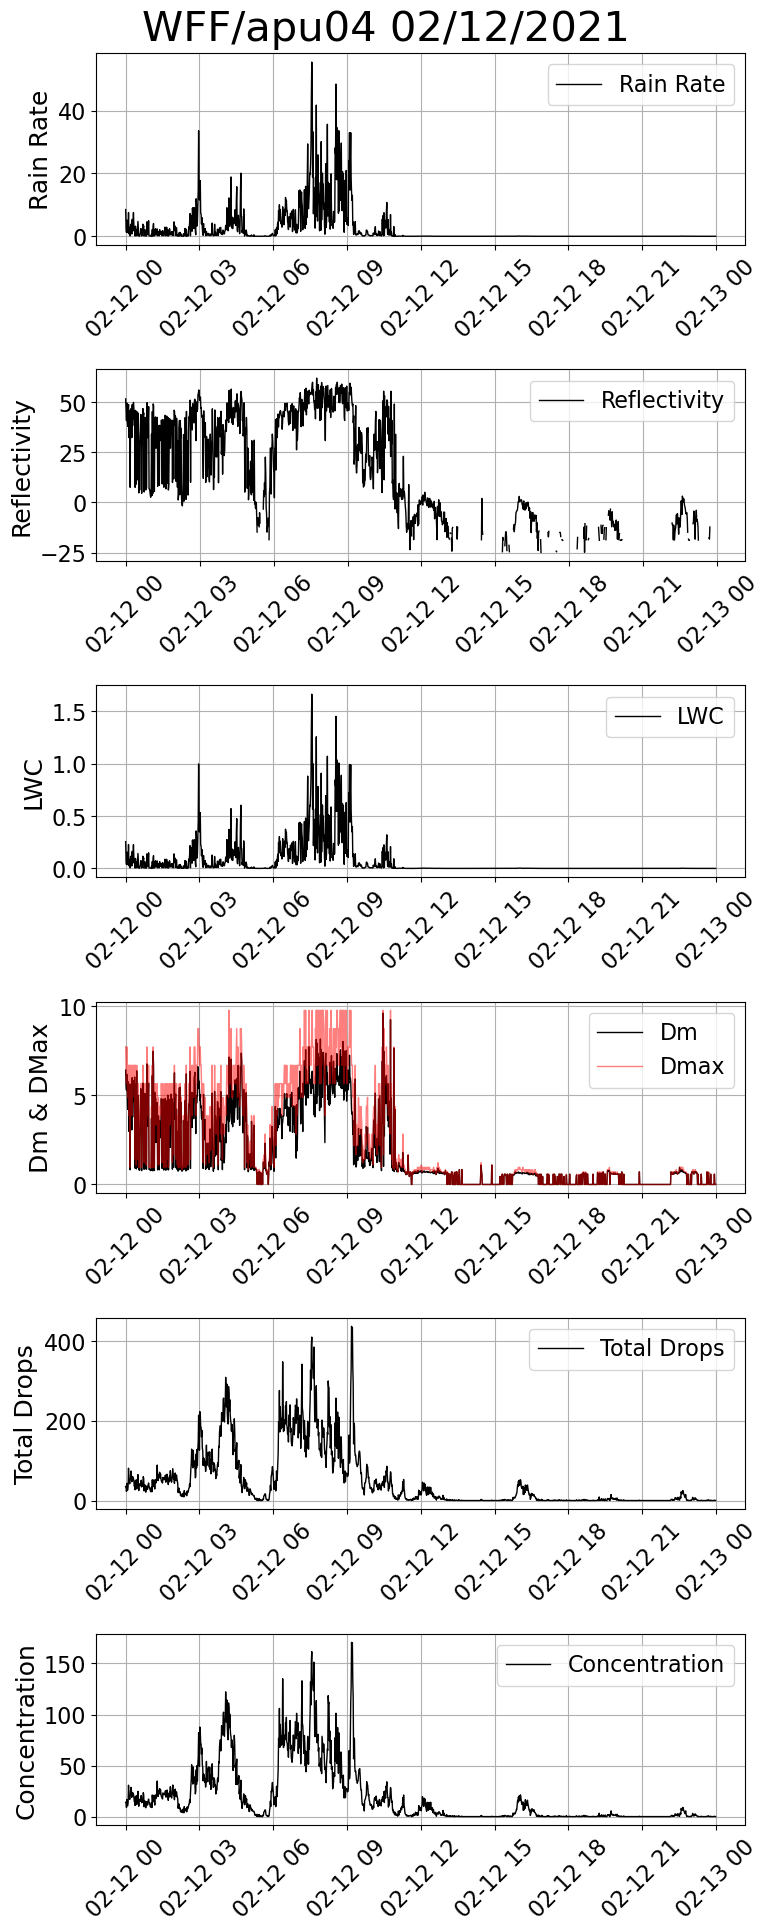

In [5]:
# Generate plot with rain rate, reflectivity, LWC, Dm/Dmax, Total Drops and Concentration
print('Generating rain image...')
rain_png_file = pltdsd.plot_integral_parameters(Parms_DF, PSD_DF, Out_Base_Dir,
                                                site, inst, syear, smonth, sday,
                                                figsize=figsize, savefig=savefig)

###  Plot the DSD mesh

Generating DSD image...


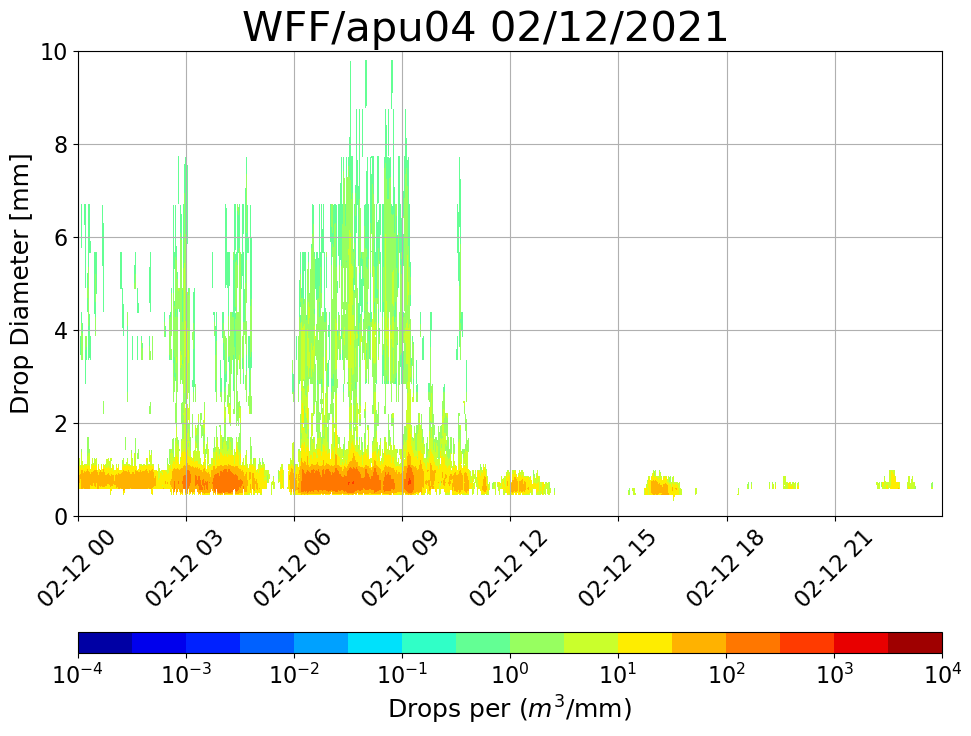

In [6]:
# Generate standalone DSD plot
print('Generating DSD image...')
dsd_png_file = pltdsd.plot_dsd(Parms_DF, PSD_DF, Out_Base_Dir,
                               site, inst, syear, smonth, sday, savefig=savefig)


### If we saved figures, create thumbnails for web display

In [7]:
if(savefig):
    # Create thumbnail of rain plot
    size_tuple = (200,400)
    rain_thumb_file = pltdsd.create_thumbnail(rain_png_file, size_tuple)

    # Create thumbnail of DSD plot
    size_tuple = (400, 200)
    dsd_thumb_file = pltdsd.create_thumbnail(dsd_png_file, size_tuple)
